In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1 #number images from the least frequent label- 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [ ]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step


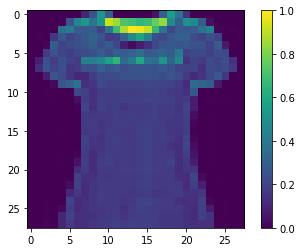

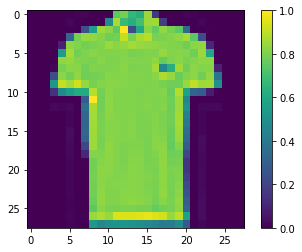

1.0


In [ ]:
# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

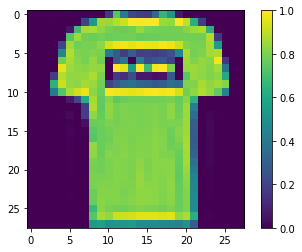

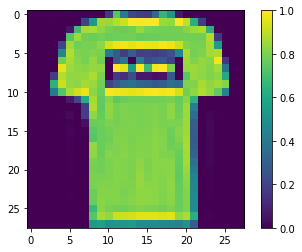

In [ ]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

In [ ]:
def initialize_base_network():
  input_layer = Input(shape=(28,28,))
  flatten = Flatten()(input_layer)
  dense1 = Dense(128, activation="selu", kernel_initializer="lecun_normal", name="dense1")(flatten)
  dout1 = Dropout(0.1, name="dout1")(dense1)
  dense2 = Dense(128, activation="selu", kernel_initializer="lecun_normal", name="dense2")(dout1)
  dout2 = Dropout(0.1, name="dout2")(dense2)
  dense3 = Dense(128, name="dense3")(dout2)
  return Model(inputs= input_layer, outputs = dense3)

def euclidian_distance(vecs):
  v1, v2 = vecs
  return K.sqrt( K.maximum(  K.sum( K.square(v1-v2), axis=1, keepdims=True), K.epsilon() ) ) 

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

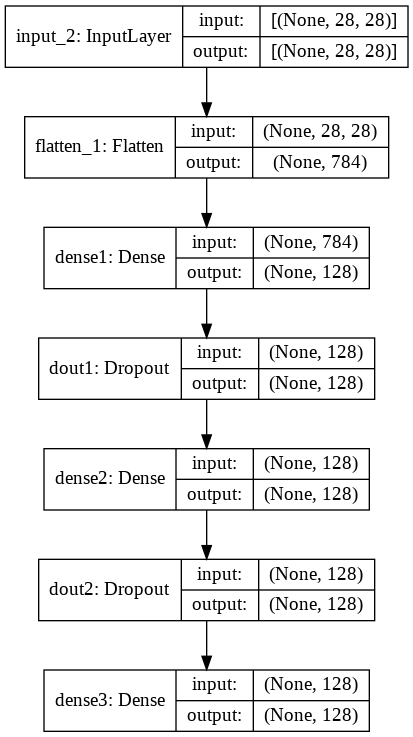

In [ ]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

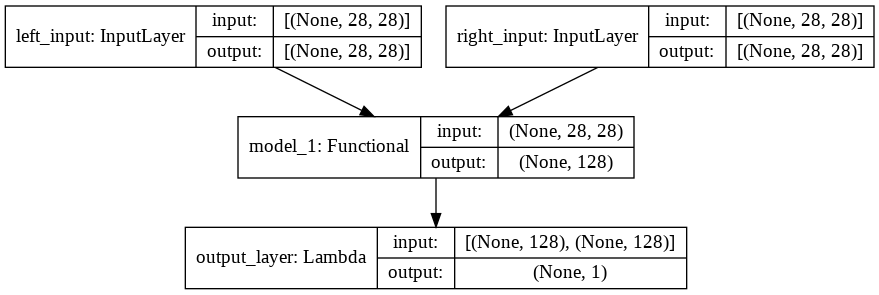

In [ ]:
#Create the left input to the Siamese network. 
input_left = Input(shape=(28,28), name="left_input")
vect_output_left = base_network(input_left)

input_right = Input(shape=(28,28), name="right_input")
vect_output_right = base_network(input_right)

output = Lambda(euclidian_distance, name="output_layer", output_shape = eucl_dist_output_shape)([vect_output_left, vect_output_right])

model = Model(inputs = [input_left, input_right], outputs = output)

plot_model(model, show_shapes=True, show_layer_names=True, to_file="outer_model.png")



In [ ]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss 

In [ ]:
rms = RMSprop(momentum=0.9)
model.compile(loss= contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 10s 9ms/step - loss: 1.4851 - val_loss: 0.1429
Epoch 2/20
938/938 [==============================] - 8s 9ms/step - loss: 0.2183 - val_loss: 0.1466
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2201 - val_loss: 0.1286
Epoch 4/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2217 - val_loss: 0.1369
Epoch 5/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2180 - val_loss: 0.1307
Epoch 6/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2166 - val_loss: 0.1443
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2187 - val_loss: 0.1652
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2163 - val_loss: 0.1336
Epoch 9/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2193 - val_loss: 0.1507
Epoch 10/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2176 - val_loss: 0.134